### This Program tries to predict whether a particle is a Higgs boson based on collision data.

The data set comes from Hugging face: https://huggingface.co/datasets/mstz/higgs and we compare our performances with the ones published in the following article : https://www.nature.com/articles/ncomms5308/ 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import neighbors
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn import ensemble

from multiprocessing import cpu_count  # define this in order to run some computations in parallel
n_cpu = cpu_count()-1  

In [2]:
df = pd.read_csv('higgs.csv')
print(df.shape)
print(df.columns)

(98050, 29)
Index(['is_boson', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', ' m_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')


C:\Users\maxme\AppData\Local\Temp\ipykernel_16624\2936223347.py:1: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('higgs.csv')


This warning means that some columns have data of different types. Let us look at the shape of the data frame and fetch the name of the problematic columns.



We will therefore convert all data to floats. 
If the data is of string type that can't be converted, the argument 'coerce' will convert them to NaN.

We then drop all rows that have a NaN. The argument 'inplace' modifies the dataframe without creating a new one.

In [3]:
for column in ['jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', ' m_jlv', 'm_bb', 'm_wbb', 'm_wwbb']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df.dropna(inplace=True)

len(df)

98049

We see that there was just one problematic row and we got rid of it. 

100 000 rows is high. For most of the training I used a 10% sample. 
Here I put frac=1 because in what follows I chose all my models and hyperparameters, so I want to use the full dataset.

In [4]:
df_reduced = df.sample(frac=1, random_state=77) 
# the fixed random_state is for reproducibility purposes

In [5]:
feature_names = list(df_reduced.columns)  # creates a list with the name of all the columns
target = feature_names.pop(0)  # creates our target variable and removes it from the features list
n_features = len(feature_names) #number of features

Let us do some data visualisation on our features. There's around 30 columns so let us display all of them at once.

In [6]:
# We define the function multiplot that plots all our features at once for a given data set.

def multiplot(data, n_plot):
    n_cols = 5  # number of columns we want to display
    n_rows = (n_plot + n_cols - 1) // n_cols  # This line calculates the number of rows needed for the grid. 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

    for idx, column in enumerate(feature_names):
       ax = axes[idx // n_cols, idx % n_cols]
       ax.hist(data[column], bins=50)
       ax.set_title(column)

    plt.tight_layout()
    plt.show()

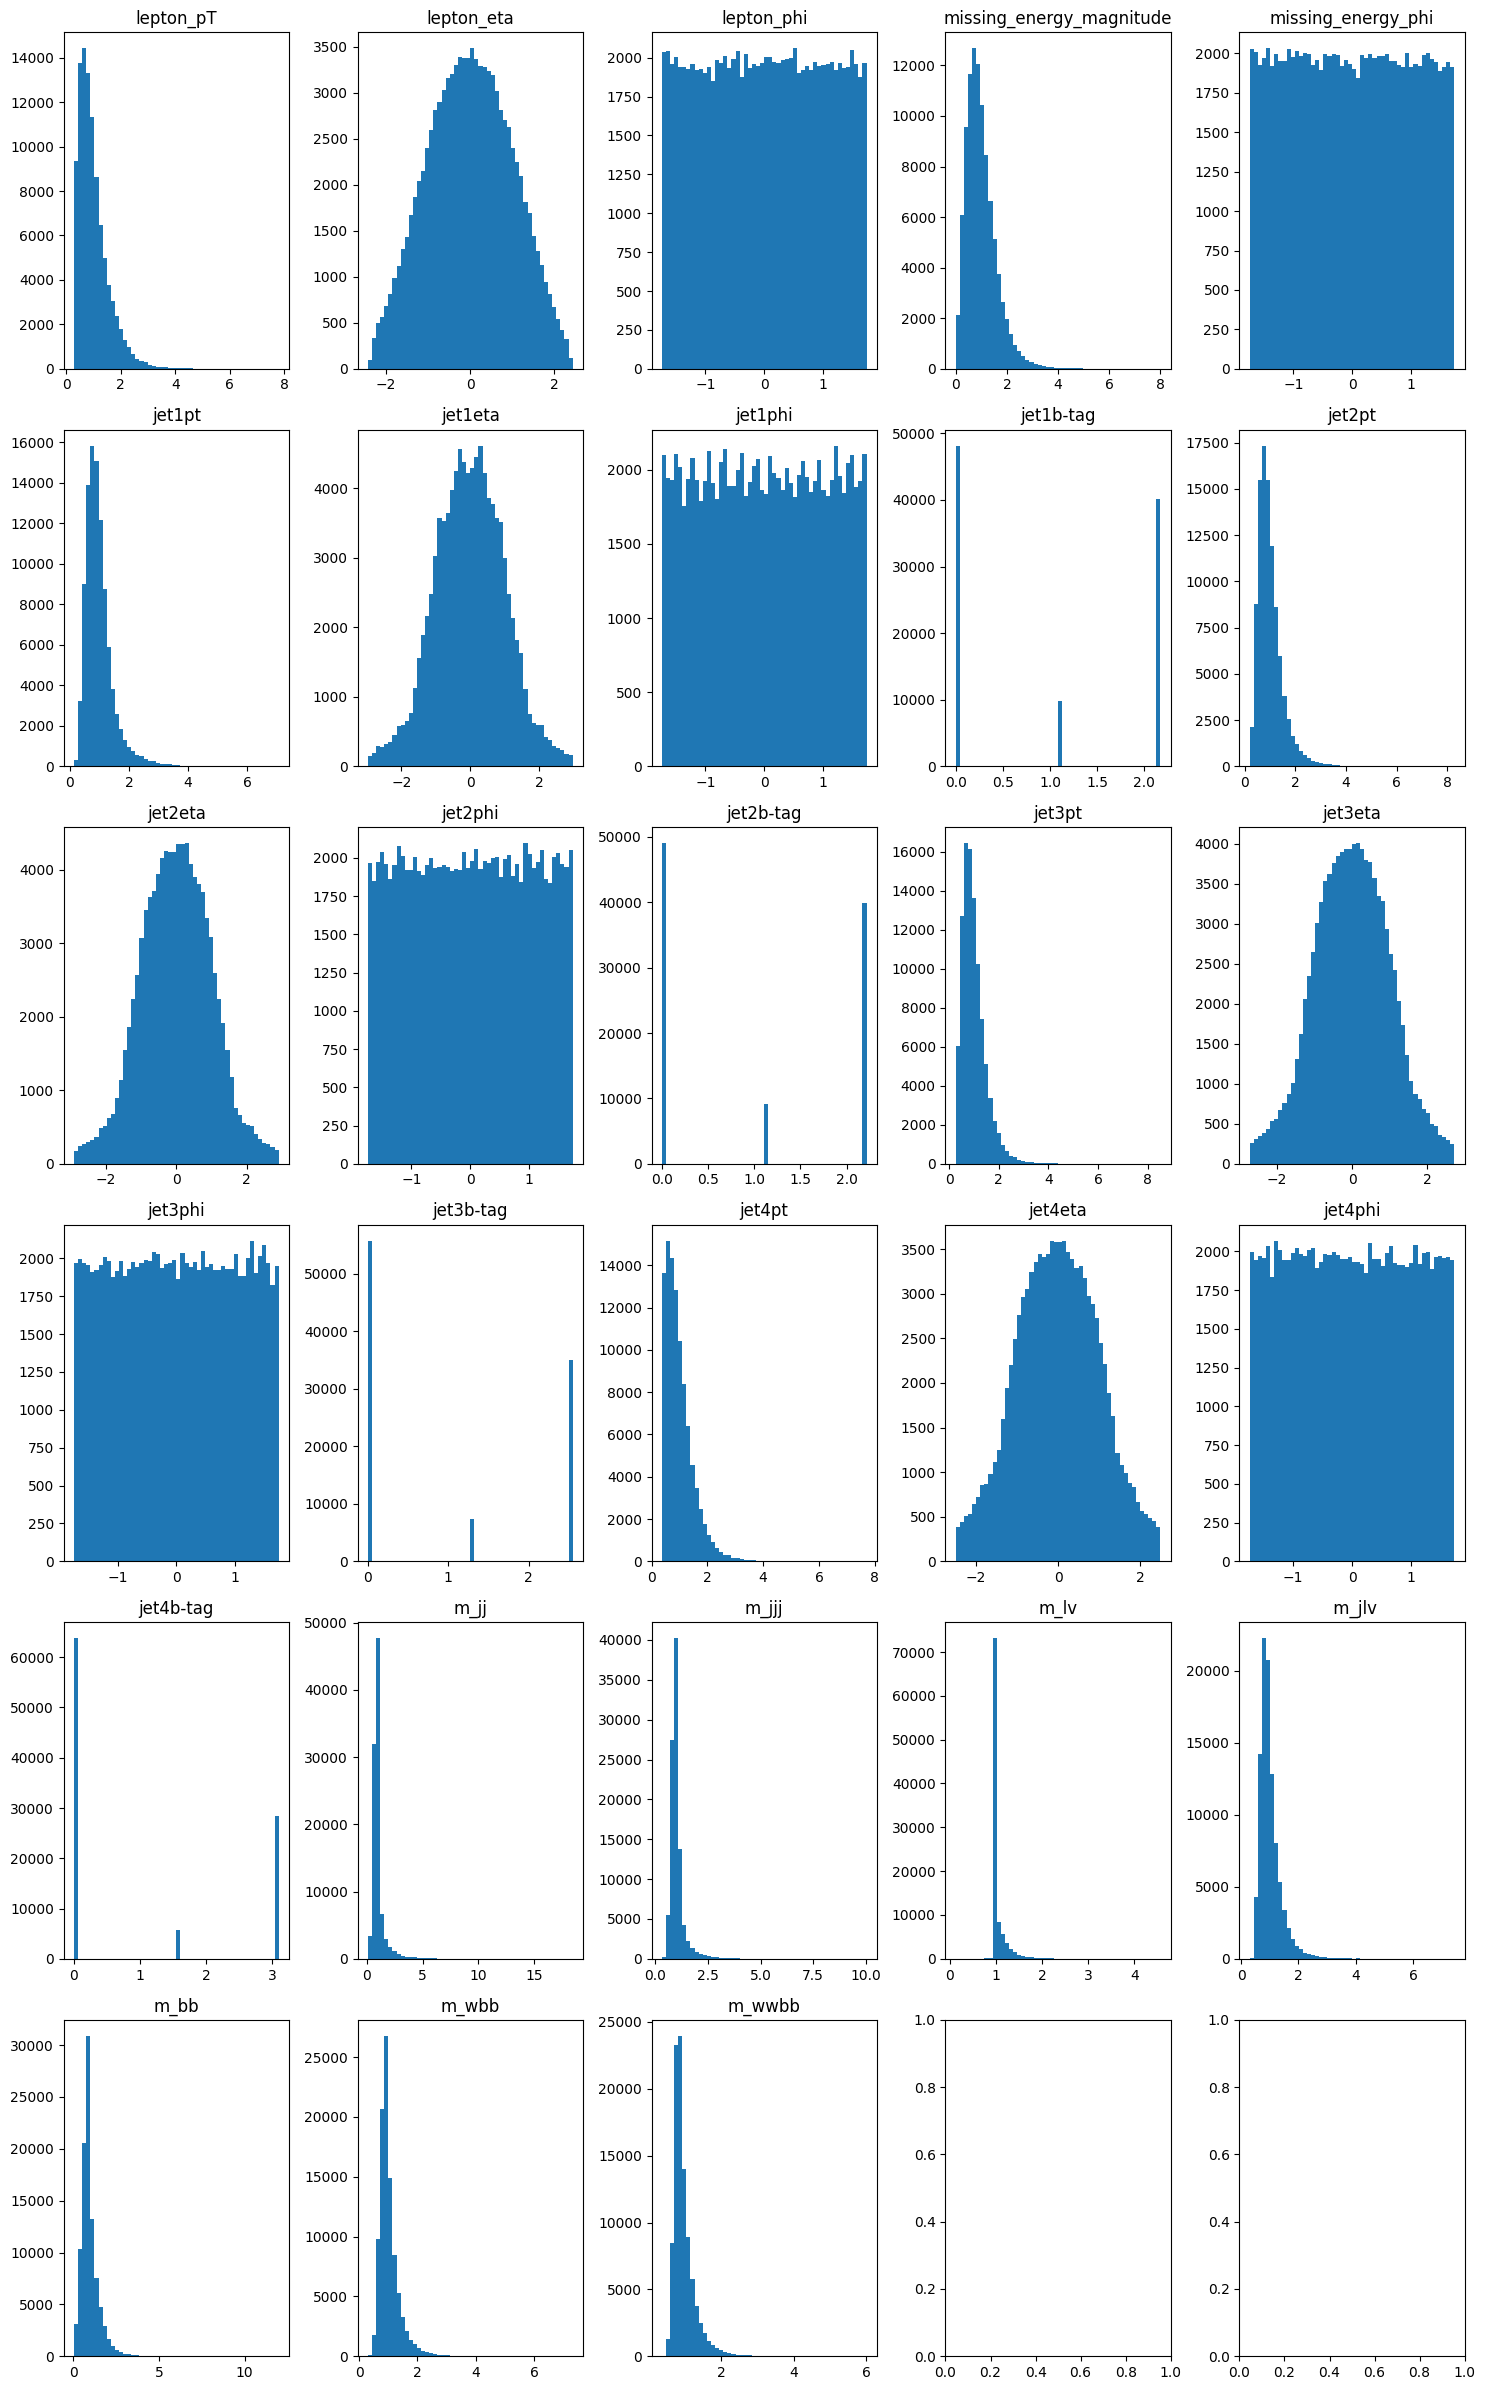

In [7]:
multiplot(df_reduced, n_features)

We see that some features are uniformly distributed, some are gaussian and some are sparse. 
We notice that a few features have a thin but long tail like 'm_jj' and 'm_jjj', which could be a problem in the case of KNN.
Indeed a few outliers means that after scaling, the majority of the data of such features will be squashed, and hence this feature will essentially be useless for most data except for outliers. 
The way we deal with this here is by applying a logarithm before scaling because for all of our features with tails, the data is positive.

In [8]:
df_reduced['m_jj'] = df['m_jj'].apply(np.log10)
df_reduced['m_jjj'] = df['m_jjj'].apply(np.log10)

We now select the features we are interested in (here I kept everything), and we want to predict Y.

In [9]:
# features= ['lepton_pT', 'lepton_eta', 'lepton_phi','missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta','jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag','jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta','jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', ' m_jlv', 'm_bb','m_wbb', 'm_wwbb']
X=df_reduced[feature_names]
Y=df_reduced[target]

Our target is "is_boson" saying whether or not a colission produced a Higgs boson. 
Let us check that the target is balanced.

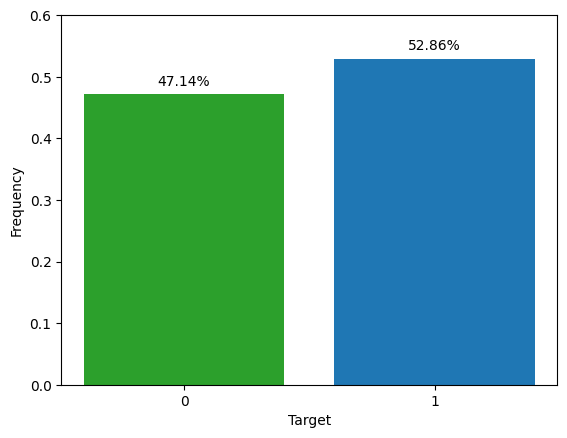

In [10]:
target_frequencies = df_reduced[target].value_counts(normalize='true')
bars = plt.bar(target_frequencies.index, target_frequencies.values, color=['tab:blue', 'tab:green'])
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0, 1])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.01, 
        f'{height:.2%}', ha='center', va='bottom',
    )
plt.ylim([0, 0.6])
plt.show()

We see that our target is pretty balanced, moreover it could give us a naive baseline for the minimal accuracy our model needs to have.

Let us start with a KNN algorithm. First thing to do is normalizing the data, meaning we want columns to have a mean of 0 and a standard deviation of 1

In [11]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

We check that our data is indeed scaled as wanted.

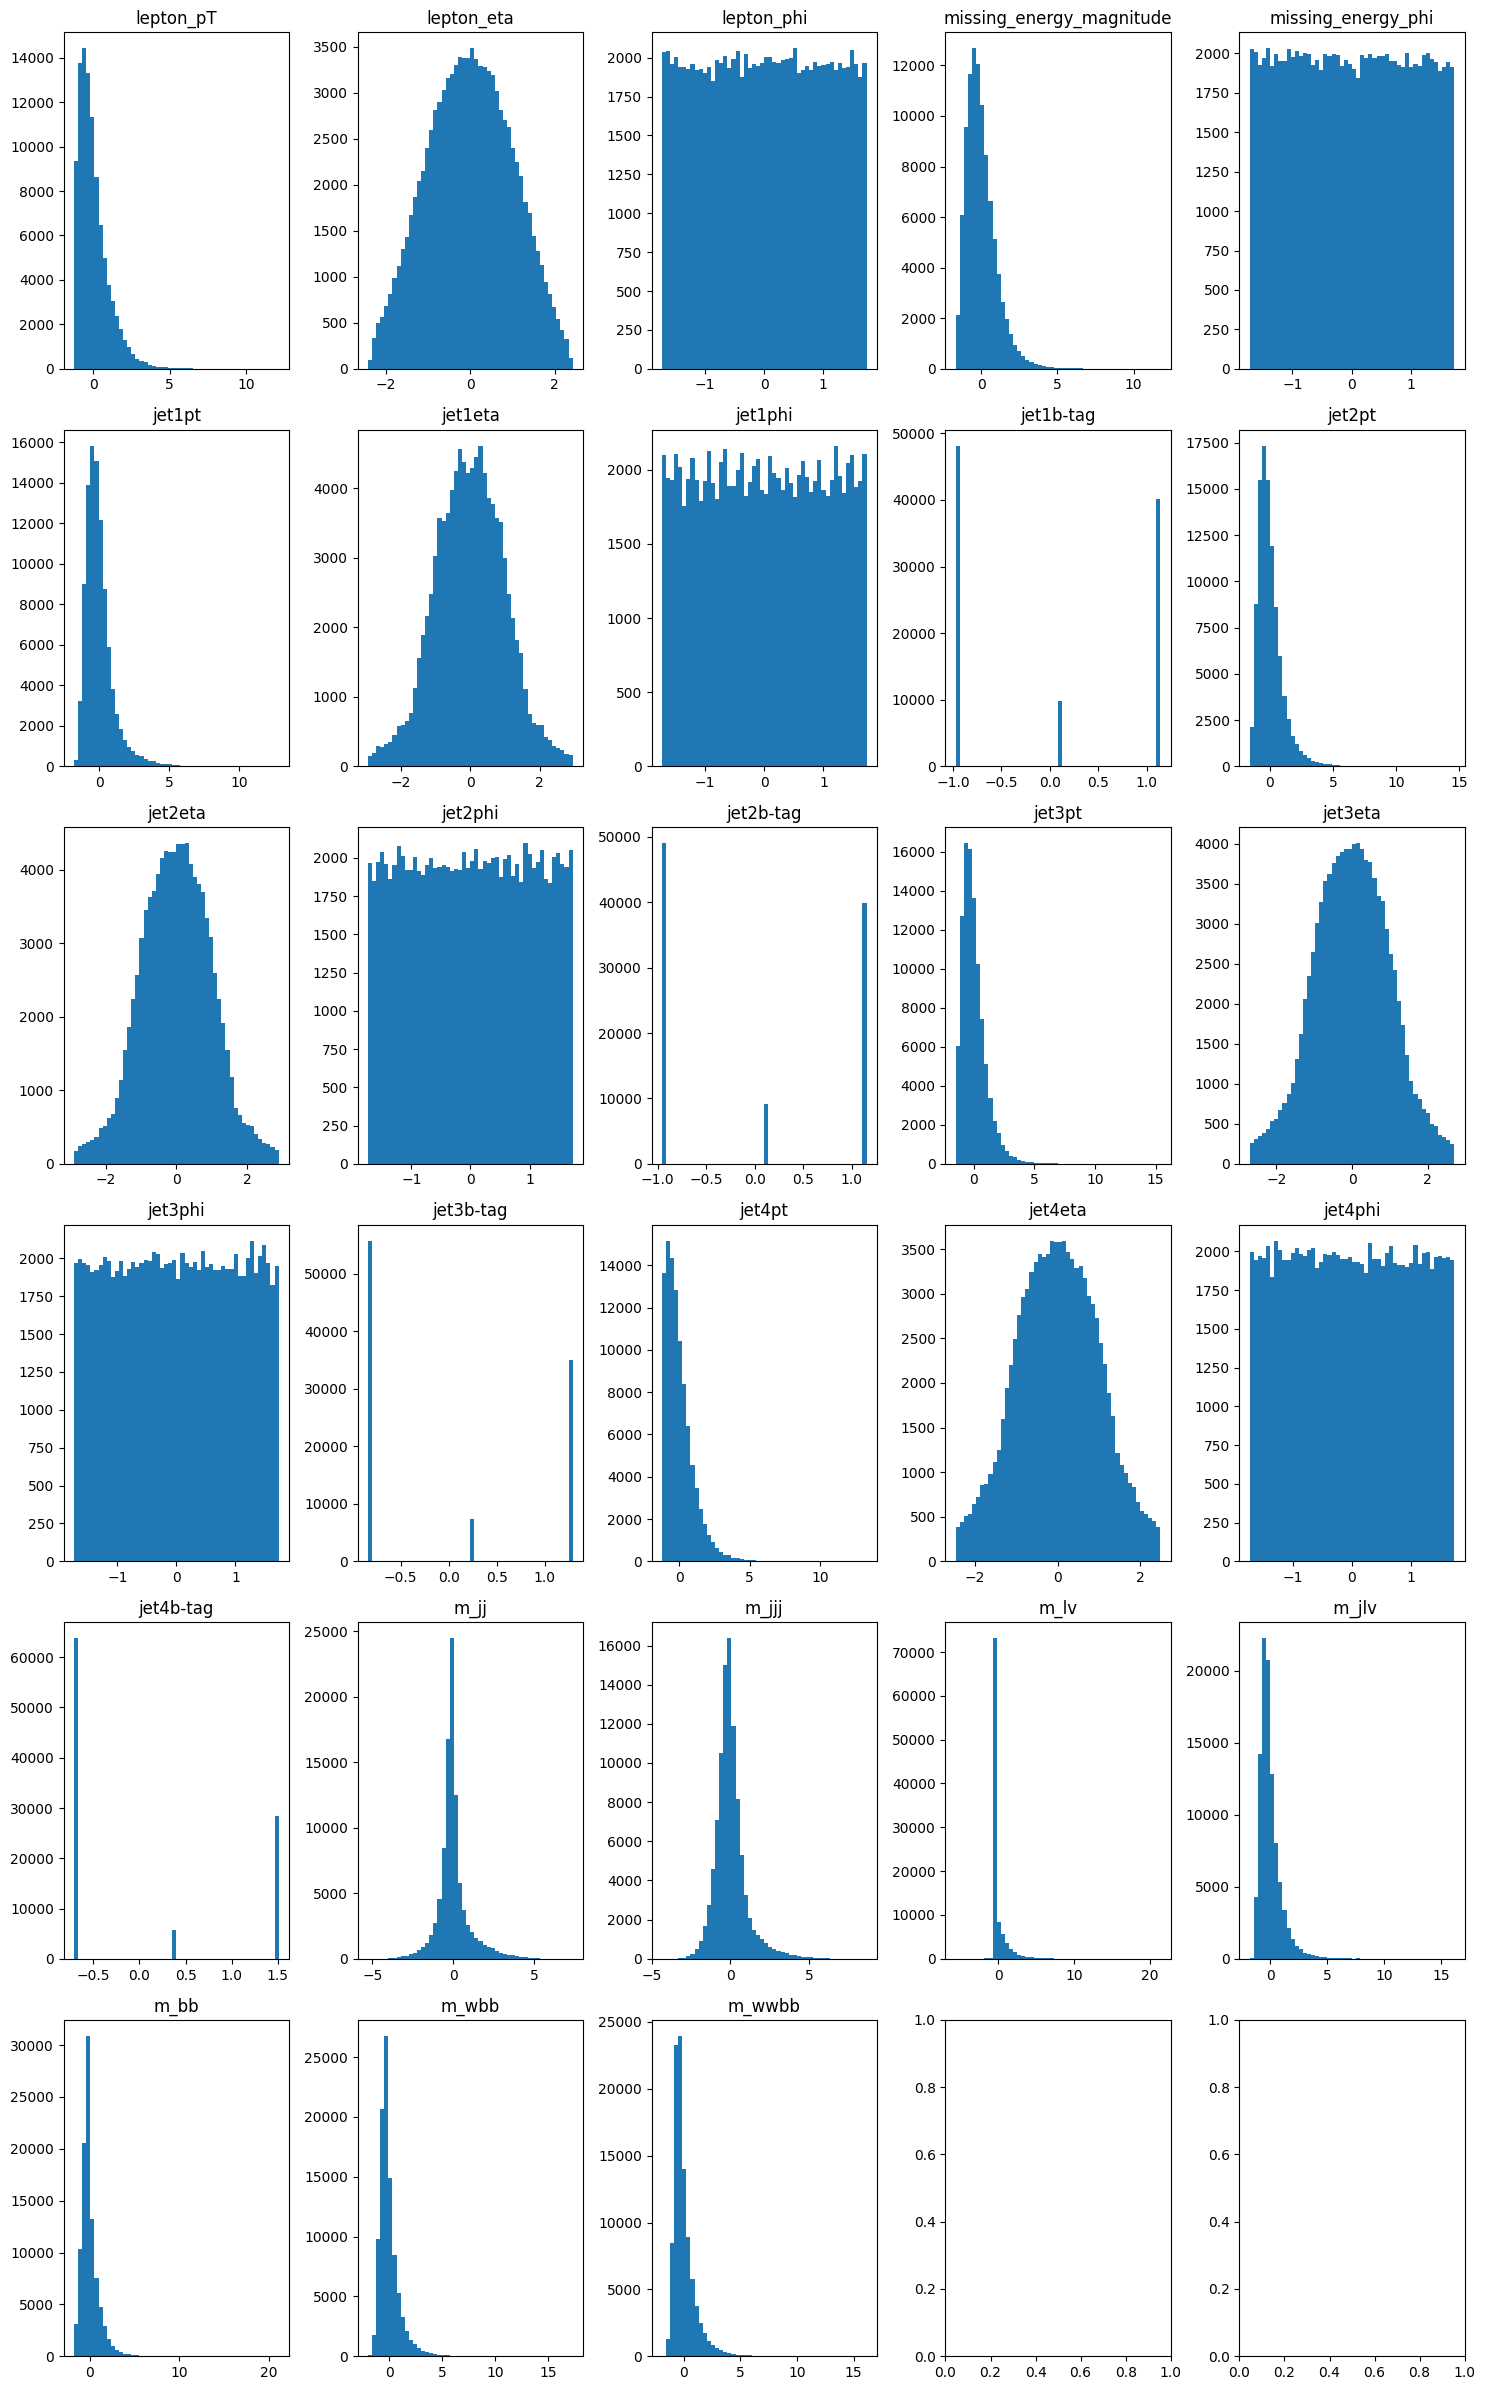

In [12]:
multiplot(X_standardized, n_features)

In [13]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)

In [14]:
# Fix the values of hyperparameters we want to test.
param_grid = {'n_neighbors':list(range(35, 46))}

# We choose a score to optimise, here it will be the roc_auc (area under the ROC curve, check literature for details)
# We choose this score because it's the one chosen from the paper so that we can compare performances.
score = 'roc_auc'

# We create a kNN classifier who searches for hyperparameters by crossed validation
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # kNN classifier
    param_grid,     # the hyperparameters to test that we defined above
    cv=5,           # number of cross-validation folds
    scoring=score,   # score to optimize
    n_jobs=n_cpu    # number of CPUs to use in parallel to speed up
)

# We fit the models on our training set
clf.fit(X_train, Y_train)

# We print the optimal hyperparameters
print("Best hyperparameters on training set:")
print(clf.best_params_)

# We print the corresponding performances
print("Cross Validation results:")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # mean score
        clf.cv_results_['std_test_score'],  # score standard deviation
        clf.cv_results_['params']           # value of the hyperparameter
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Best hyperparameters on training set:
{'n_neighbors': 45}
Cross Validation results:
roc_auc = 0.648 (+/-0.009) for {'n_neighbors': 35}
roc_auc = 0.648 (+/-0.009) for {'n_neighbors': 36}
roc_auc = 0.649 (+/-0.009) for {'n_neighbors': 37}
roc_auc = 0.649 (+/-0.010) for {'n_neighbors': 38}
roc_auc = 0.649 (+/-0.010) for {'n_neighbors': 39}
roc_auc = 0.650 (+/-0.010) for {'n_neighbors': 40}
roc_auc = 0.650 (+/-0.010) for {'n_neighbors': 41}
roc_auc = 0.650 (+/-0.010) for {'n_neighbors': 42}
roc_auc = 0.650 (+/-0.010) for {'n_neighbors': 43}
roc_auc = 0.650 (+/-0.011) for {'n_neighbors': 44}
roc_auc = 0.650 (+/-0.011) for {'n_neighbors': 45}


Various values of the hyperparameter k have been tested. The optimum was always near $k$=40. 
When keeping 10% of the data set the roc_auc was around 0.66. On the full data set, the accuracy is around 0.70. 

Here we kept all features (around 30).
Maybe that's too many features. 
In order to counteract the curse of dimensionality,
we now attempt to do a PCA in order to keep only the most relevant features, in order to improve our performance. 

caveat: as explained in the scientific paper, our problem is in fact non-linear with respect to the features. 
We therefore have reasons to believe that the PCA will perform poorly. 
We carry on regardless for pedagogical purposes. 
One way to improve would be instead to do a feature selection based on a "mutual information" method which can work in the non-linear case. 

In [15]:
pca = PCA()  # I didn't specify n_components because I don't know how many I want to retain yet.
pca.fit(X_standardized)

PCA()

Technically I should do the pca on the train set and not on the whole set to make sure we can generalize accurately. 
This would be tedious in our case as we would need to implement the cross validation and the pca at the same time (could be done using a pipeline).
Here, we will just assume that there's not distribution shift and we will carry on. 

In [16]:
pca.explained_variance_ratio_

array([0.14478474, 0.06663501, 0.06470288, 0.04939156, 0.04786168,
       0.04622964, 0.04442304, 0.04336383, 0.04177183, 0.0389831 ,
       0.03862506, 0.03772032, 0.03677263, 0.03113522, 0.03078611,
       0.02832473, 0.02786099, 0.02677824, 0.02604406, 0.02228892,
       0.02088921, 0.01919127, 0.01771581, 0.01426007, 0.01377251,
       0.00967442, 0.00711782, 0.0028953 ])

In [17]:
scree = (pca.explained_variance_ratio_*100)
scree.round(2)

array([14.48,  6.66,  6.47,  4.94,  4.79,  4.62,  4.44,  4.34,  4.18,
        3.9 ,  3.86,  3.77,  3.68,  3.11,  3.08,  2.83,  2.79,  2.68,
        2.6 ,  2.23,  2.09,  1.92,  1.77,  1.43,  1.38,  0.97,  0.71,
        0.29])

In [18]:
scree_cum = scree.cumsum()
scree_cum.round()

array([ 14.,  21.,  28.,  33.,  37.,  42.,  46.,  51.,  55.,  59.,  63.,
        66.,  70.,  73.,  76.,  79.,  82.,  85.,  87.,  89.,  92.,  93.,
        95.,  97.,  98.,  99., 100., 100.])

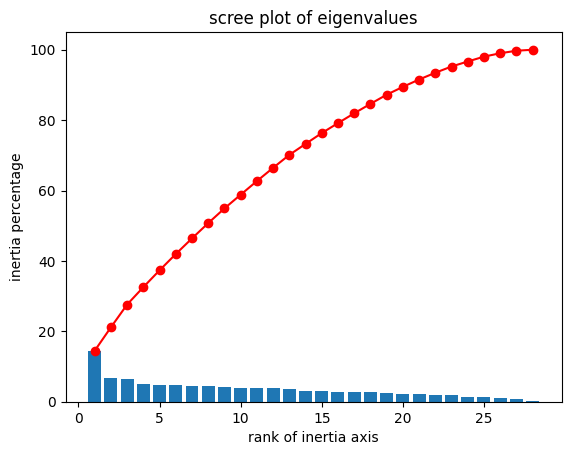

In [19]:
x_list = list(range(1, n_features+1))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rank of inertia axis")
plt.ylabel("inertia percentage")
plt.title("scree plot of eigenvalues")
plt.show(block=False)

According to the elbow method, I should only keep the first component, which explains only 14% of the variance. We can already see that our PCA is not promising. 

In [20]:
pcs = pca.components_

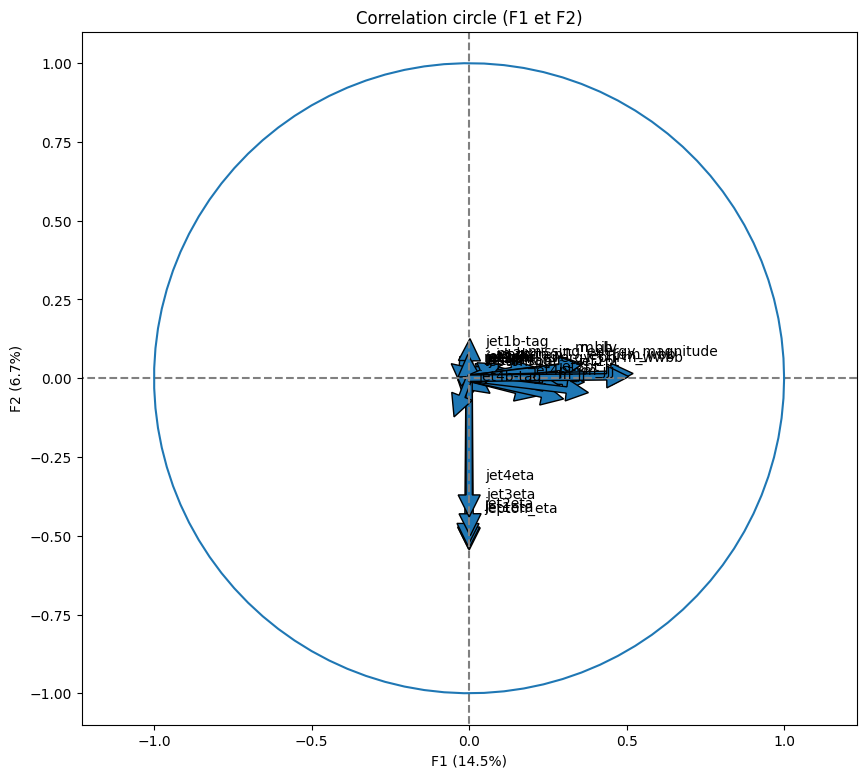

In [21]:
x, y = 0, 1  # Defining our axes

fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              
    )  

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             feature_names[i])
    
# display horizontal and vertical lines
plt.axvline(x=0, ymin=-1, ymax=1, color='grey', ls='--')
plt.axhline(y=0, xmin=-1, xmax=1, color='grey', ls='--')

# name of axes, with the associated percentage of inertia
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Correlation circle (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

We can see that some features are indeed correlated but none of the arrows are very long, they are now well represented by our new components as we expected

In [22]:
X_proj = pca.transform(X_standardized)

We conclude that it is unclear how many components we want to keep. We will therefore treat the number of components to keep as a hyperparameter: n_components and test every choice with $k$ the number of neighbors in the kNN.

In [23]:
for n_components in [25]:
    pca = PCA(n_components=n_components)
    pca.fit(X_standardized)
    X_proj = pca.transform(X_standardized)
    X_train_temp, X_test_temp, Y_train_temp, Y_test_temp = model_selection.train_test_split(X_proj, Y, test_size=0.2)
    
    # Fix the values of hyperparameters we want to test.
    param_grid = {'n_neighbors':[50]}

    # We choose a score to optimise, here it will be the accuracy (meaning the proportion of correct predictions)
    score = 'roc_auc'

    # We create a kNN classifier who searches for hyperparameters by crossed validation
    clf = model_selection.GridSearchCV(
        neighbors.KNeighborsClassifier(), # kNN classifier
        param_grid,     # the hyperparameters to test that we defined above
        cv=5,           # number of cross-validation folds
        scoring=score   # score to optimize
    )

    # We fit the models on our training set
    clf.fit(X_train_temp, Y_train_temp)

    # We print the optimal hyperparameters
    print("Best hyperparameters on training set:")
    print(clf.best_params_)

    # We print the corresponding performances
    print("Cross validation results:")
    for mean, std, params in zip(
            clf.cv_results_['mean_test_score'], # mean score
            clf.cv_results_['std_test_score'],  # score standard deviation
            clf.cv_results_['params']           # value of the hyperparameter
            ):

        print("{} = {:.3f} (+/-{:.03f}) for {}".format(
            score,
            mean,
            std*2,
            params
        ) )

Best hyperparameters on training set:
{'n_neighbors': 50}
Cross validation results:
roc_auc = 0.702 (+/-0.003) for {'n_neighbors': 50}


I tested on many hyperparameters for 10% of the data. The optimum was for k=50 and C=25. 
Our roc_auc=0.70, which is exactly the same as the kNN without PCA. 

As explained above we expected the PCA to not perform well and it is indeed the case. In order to improve our performance, we try another model and turn to random forests.

In [24]:
param_grid = {
    'n_estimators': [200, 500, 900],
    'max_depth': [5, 10, 20],
}

# We choose a score to optimise, here we pick roc_auc to compare with the paper
score = 'roc_auc'

# We create a kNN classifier who searches for hyperparameters by crossed validation
clf = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(), # random forest classifier
    param_grid,     # the hyperparameters to test that we defined above
    cv=None,           # number of cross-validation folds
    scoring=score, # score to optimize
    n_jobs=n_cpu,
    return_train_score=True,
)

# We fit the models on our training set
clf.fit(X_train, Y_train)

# We print the optimal hyperparameters
print("Best hyperparameters on training set:")
print(clf.best_params_)

# We print the corresponding performances
print("Cross validation results:")
for mean_train_score, std_train, mean_test_score, std_test, params in zip(
        clf.cv_results_['mean_train_score'],
        clf.cv_results_['std_train_score'],  # score standard deviation
        clf.cv_results_['mean_test_score'], # mean score
        clf.cv_results_['std_test_score'],  # score standard deviation
        clf.cv_results_['params']           # value of the hyperparameter
    ):

    print(f'Params: {params}')
    print(f'- train_score = {mean_train_score:.03f} +/- {std_train*2:.03f}')
    print(f'- test_score = {mean_test_score:.03f} +/- {std_test*2:.03f}')
    print()

Best hyperparameters on training set:
{'max_depth': 20, 'n_estimators': 900}
Cross validation results:
Params: {'max_depth': 5, 'n_estimators': 200}
- train_score = 0.761 +/- 0.002
- test_score = 0.752 +/- 0.009

Params: {'max_depth': 5, 'n_estimators': 500}
- train_score = 0.760 +/- 0.003
- test_score = 0.750 +/- 0.008

Params: {'max_depth': 5, 'n_estimators': 900}
- train_score = 0.761 +/- 0.002
- test_score = 0.752 +/- 0.009

Params: {'max_depth': 10, 'n_estimators': 200}
- train_score = 0.855 +/- 0.002
- test_score = 0.783 +/- 0.007

Params: {'max_depth': 10, 'n_estimators': 500}
- train_score = 0.856 +/- 0.001
- test_score = 0.783 +/- 0.007

Params: {'max_depth': 10, 'n_estimators': 900}
- train_score = 0.856 +/- 0.001
- test_score = 0.783 +/- 0.007

Params: {'max_depth': 20, 'n_estimators': 200}
- train_score = 1.000 +/- 0.000
- test_score = 0.796 +/- 0.006

Params: {'max_depth': 20, 'n_estimators': 500}
- train_score = 1.000 +/- 0.000
- test_score = 0.797 +/- 0.006

Params: {'ma

In [25]:
best_model = clf.best_estimator_
best_model

RandomForestClassifier(max_depth=20, n_estimators=900)

In [26]:
Y_pred = best_model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(Y_test, Y_pred)
print(test_score)

0.8050501877217553


(Took some time, if want to rerun do it with chosen hyperparameters).

In [27]:
# Train the best model on the whole training set
best_model.fit(X_train, Y_train)

# Training score
Y_pred_train = best_model.predict_proba(X_train)[:, 1]
train_score = roc_auc_score(Y_train, Y_pred_train)

# Test the final model on the test set
Y_pred = best_model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(Y_test, Y_pred)

print("\nTraining set roc_auc: {:.3f}".format(train_score))
print("\nTest set roc_auc: {:.3f}".format(test_score))


Training set roc_auc: 1.000

Test set roc_auc: 0.805


We see that our training score is 1 whence we are overfitting, but after many trials it is with these parameters that we obtained best performance on validation set. We could delve further maybe using XGBoost, but we can compare our test score performance with the one obtained in the paper page 7. For a boosted decision tree and shallow neural network, performance is around 0.81 when keeping all features, so we almost reproduced the performance from the paper. In order to improve further the performance, they used deep neural networks. We are therefore satisfied with our model.